In [5]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util

# データの読み込み
df = pd.read_excel('processed_terms.xlsx')

# BERTモデルのロード
model = SentenceTransformer('all-MiniLM-L6-v2')

# 定義文のベクトル化
embeddings = model.encode(df['definition'].tolist(), convert_to_tensor=True)

# 類似度の計算
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)

In [7]:
# CUDAからCPUに移動してNumPy配列に変換
cosine_scores = cosine_scores.cpu().numpy()

In [34]:
np.save('data/cosine_scores.npy', cosine_scores)


In [35]:
# 関数の定義
def get_similar_definitions(term, lower_threshold=0.5, upper_threshold=0.8):
    term_indices = df[df['term'] == term].index.tolist()
    
    if not term_indices:
        return f"Term '{term}' not found in the dataset."
    
    valid_entries = []
    for idx in range(len(df)):
        if df['term'].iloc[idx] != term:
            max_similarity = max(cosine_scores[idx][term_indices])
            if lower_threshold <= max_similarity <= upper_threshold:
                valid_entries.append((df['term'].iloc[idx], df['definition'].iloc[idx], max_similarity))
    
    # データフレームに変換して返す
    similar_definitions = pd.DataFrame(valid_entries, columns=['term', 'definition', 'similarity'])
    
    return similar_definitions

# 使用例
term = 'duty'  # 指定したい単語
similar_definitions = get_similar_definitions(term)

In [42]:
similar_definitions["term"].drop_duplicates().sample(4).values

array(['principle', 'excuse', 'industry', 'initiative'], dtype=object)

In [21]:
(cosine_scores- np.eye(len(cosine_scores))).max(axis=1) - (cosine_scores- np.eye(len(cosine_scores))).min(axis=1)

array([0.99475601, 1.13802837, 0.83372848, ..., 0.95836306, 0.69326716,
       0.81044225])

In [2]:
df

,term,definition,usage,processed_definition
0,respond,to give a spoken or written answer to someone ...,"""I asked him his name, but he didn't respond....","[give, spoken, written, answer, someone, somet..."
1,respond,to do something as a reaction to something tha...,"""How did they respond to the news?""\n""The gov...","[something, reaction, something, someone, said..."
2,respond,to react quickly or in the correct way to some...,"""The car responds very well to the controls.""...","[react, quickly, correct, way, something, some..."
3,response,a spoken or written answer,"""She made no response.""\n""In response to you...","[spoken, written, answer]"
4,response,a reaction to something that has happened or b...,"""The news provoked an angry response.""\n""a po...","[reaction, something, happened, said]"
...,...,...,...,...
8888,allow,"to let someone or something go into, through, ...","""No dogs allowed (= you cannot bring them in)...","[let, someone, something, go, etc, place]"
8889,allow for,to consider or include someone or something wh...,"""It will take about an hour to get there, allo...","[consider, include, someone, something, calcul..."
8890,all right,acceptable; in an acceptable manner,"""Is the coffee all right?""\n""Are you getting ...","[acceptable, acceptable, manner]"
8891,all right,safe and well,"""I hope the children are all right.""\n""Do you...","[safe, well]"


In [3]:
# Word2Vecモデルをトレーニング
model = Word2Vec(df['processed_definition'], vector_size=20, window=5, min_count=4, workers=4)

# 定義のベクトルを計算
def get_definition_vector(definition):
    words = preprocess_text(definition)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return sum(word_vectors) / len(word_vectors)
    else:
        return None

df['definition_vector'] = df['definition'].map(get_definition_vector)
print(len(df))
df = df.dropna(subset=['definition_vector'])
print(len(df))

8893
8856


In [4]:
df['definition_vector']

0       [-0.28969523, -0.0044496567, 0.41091046, 0.121...
1       [-0.30902022, -0.016677683, 0.42486122, 0.1191...
2       [-0.28213012, 0.018198324, 0.3824058, 0.105583...
3       [-0.1645499, 0.0071708285, 0.24807613, 0.10257...
4       [-0.21644773, -0.013518977, 0.28675202, 0.0918...
                              ...                        
8888    [-0.35110262, -0.00921421, 0.41981217, 0.14915...
8889    [-0.29240614, -0.027238186, 0.40592328, 0.1038...
8890    [-0.085035436, -0.014396536, 0.23307776, 0.054...
8891    [-0.15117326, 0.0054118615, 0.17402571, 0.0723...
8892    [-0.2689566, 0.020560954, 0.43441147, 0.115954...
Name: definition_vector, Length: 8856, dtype: object

In [5]:
import numpy as np

def find_similar_definitions(target_vector, top_n=10):
    similarities = df['definition_vector'].map(lambda x: np.dot(x, target_vector))
    return similarities

# 例として、最初の単語の定義を基に選択肢を作成
row = df.sample(1).iloc[0]
target_definition_vector = row['definition_vector']
print(target_definition_vector)
similarities = find_similar_definitions(target_definition_vector)

# print(f"単語: {row['term']}, 定義: {row['definition']}")
# # 選択肢を表示
# for index, row in similar_definitions_df.iterrows():
#     print(f"単語: {row['term']}, 定義: {row['definition']}")

top_n = 100
similar_indices = similarities.nlargest(top_n + 1).index
display(df.loc[similar_indices])

[-0.317717   -0.00801581  0.4086543   0.17147079 -0.4689266  -0.1657577
 -0.16993819  1.072211   -0.50706357  0.06308155  1.0576671  -0.33372992
  0.2615611  -0.27484098  0.75604266  0.6091417   0.987827   -0.32506496
 -1.0411541  -1.2707291 ]


,term,definition,usage,processed_definition,definition_vector
775,industrial,used by industries,""" industrial chemicals""","[used, industries]","[-0.4074085, 0.025645, 0.6056551, 0.16244493, ..."
5321,living,used or practiced now,""" living languages (= those still spoken)""\n""a...","[used, practiced]","[-0.4074085, 0.025645, 0.6056551, 0.16244493, ..."
5699,have,be made up of,"""In 2008 the party had 10,000 members.""",[made],"[-0.46906608, -0.048427206, 0.6064385, 0.24698..."
7016,e.g.,for example (from Latin‘exempli gratia’),"""popular pets ( e.g., cats and dogs)"">","[example, latinexempli, gratia]","[-0.45500967, 0.0145133175, 0.599977, 0.295775..."
459,smooth,without any lumps,"""Mix the flour with the milk to form a smooth...","[without, lumps]","[-0.36291134, -0.016470421, 0.6222975, 0.17910..."
...,...,...,...,...,...
5348,past,gone by in time,"""in past years/centuries/ages""\n""in times pa...","[gone, time]","[-0.41063052, -0.014413495, 0.42693654, 0.1298..."
6171,increasingly,more and more all the time,""" increasingly difficult/important/popular""\n""...",[time],"[-0.41063052, -0.014413495, 0.42693654, 0.1298..."
4037,solid,strong and made well,"""These chains seem fairly solid.""\n\n>","[strong, made, well]","[-0.3533963, -0.030816182, 0.47496447, 0.19708..."
44,shadow,a very small amount of something,"""A shadow of a smile touched his mouth.""\n""Sh...","[small, amount, something]","[-0.39568582, 0.0009829054, 0.49806297, 0.1896..."


<Axes: xlabel='processed_definition'>

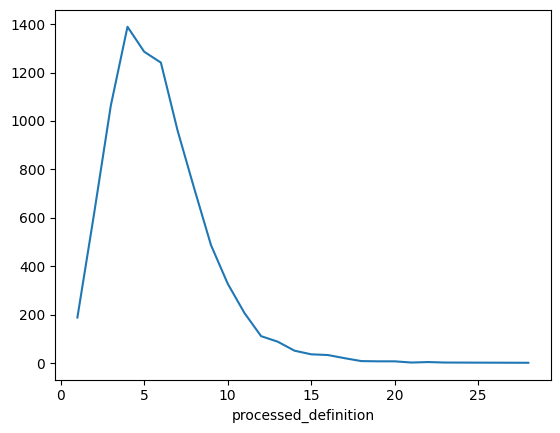

In [7]:
df["processed_definition"].map(len).value_counts().sort_index().plot()

In [59]:
similarities.nlargest(3 + 1)

5699    5.033568
775     4.859731
5321    4.859731
7016    4.835745
Name: definition_vector, dtype: float32